## Sample for optimizing a portfolio that supplies a load minimum share of green energy
In this sample, we define a more realistic example from the power sector: We define a complex sales contract, with an hourly load profile and the obligation to provide at least 80% of the power from green sources. In the portfolio we link it to a wind and a PV PPA along with a battery that allows us to flatten out green production to be abme to meet the target share of green energy.

## Some prerequisites
### Basic definitions

In [1]:
import numpy as np
import pandas as pd
import datetime as dt
import os, sys
from IPython.display import display, HTML
# in case eao is not installed, set path
myDir = os.path.join(os.getcwd(), '../..')
sys.path.append(myDir)
addDir = os.path.join(os.getcwd(), '../../../..')
sys.path.append(addDir)
import eaopack as eao

### Timegrid
The timegrid defines start and end of the optimization, including discretization and conversion unit from flow (i.e. capacity, here MW) and volume (here MWh)

In [2]:
Start = dt.date(2021,1,1)
End   = dt.date(2021,1,10)
timegrid = eao.assets.Timegrid(Start, End, freq = 'h', main_time_unit = 'h')

## Define the portfolio

### The nodes as the starting point
A node reflects a virtual trading point that all assets are connected to. In case of a setup with transport limitations, several nodes may be used. A node always comes with a commodity that is traded at it. Here it's power. Note that commodity and unit serve for documentation only

In order to clearly separate "green power" from "grey power" we define two nodes

In [3]:
green_sources = eao.assets.Node('green sources', commodity= 'power')
grey_sources  = eao.assets.Node('grey sources', commodity= 'power')

### The downstream contract
Assume we have a contract, where we are obliged to 
(1) deliver a given load profile
(2) ensure that a fraction (e.g. 80%) of the overall energy comes from green sources (our PPAs). The rest may be provided from the market
We assume we have an obligation to deliver at a fixed price.

This is a rather complex asset and we make use of the StructuredAsset. This could be done in a simpler way, but allows us to encapsulate everything in one asset.

In [4]:
min_fraction_green = 0.8
sales_fix_price    = 130

#### Starting with the load
The asset is located in it's own node to ensure delivery is channeled separate from green and grey sources
Attention: As the consumer draws power, the load must have negative sign in the contract

In [5]:
node_load = eao.assets.Node('node load', commodity= 'power')
load_profile = {'start' : timegrid.timepoints.to_list(),\
                'values':  - 5*abs(np.sin(np.pi/22 * timegrid.timepoints.hour.values)     \
                              + np.sin(0.1 + np.pi/10 * timegrid.timepoints.hour.values)\
                              + np.sin(0.2 + np.pi/3 * timegrid.timepoints.hour.values) )}
load         = eao.assets.Contract(name = 'load', min_cap= load_profile, max_cap=load_profile, extra_costs=-sales_fix_price ,nodes = node_load)
volume_sold  = -load_profile['values'].sum()
max_load     = -load_profile['values'].min()

#### Green restriction
To link green and grey sources to their delivery counterparts, we define transport assets. The green link implements a "minimum take", i.e. a minimum volume over the optimization time

In [6]:
min_green = {'start':Start, 'end':End, 'values' : volume_sold * min_fraction_green }
link_green = eao.assets.ExtendedTransport(name = 'green link', min_take = min_green,  min_cap = 0, max_cap = max_load, nodes = [green_sources, node_load])
link_grey  = eao.assets.Transport(name = 'grey link',   min_cap = 0, max_cap = 20, nodes = [grey_sources, node_load])

#### Create contract object
To wrap things up, we pack all assets together in a portfolio that defines our downstream contract. This in turn is used to define the new structured asset that connects to the outside world via the sourcing nodes

In [7]:
downstream_portfolio = eao.portfolio.Portfolio([load, link_green, link_grey])
downstream_contract  = eao.portfolio.StructuredAsset(name = 'downstream', nodes = [green_sources, grey_sources], portfolio = downstream_portfolio)

How does it look like? The network graph explains:

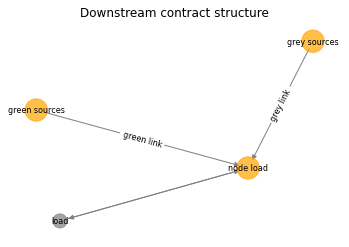

In [8]:
#eao.network_graphs.create_graph(portf = downstream_portfolio, file_name='test.eps', title = 'Downstream contract structure')
eao.network_graphs.create_graph(portf = downstream_portfolio,title = 'Downstream contract structure')

### Green energy supply PPAs: PV and wind with a given generation profile
We are using a "contract" as the asset type. This gives us the opportunity to define a detailed minimum and maximum capacity that reflects available generation according to how wind blows and sun shines. We assume those assets are PPAs. Note that the minimum capacity is the same as max. We assume we have the obligation to take off all production at the fix price. They are attached to the "green node"

In [9]:
PPA_fix_price = 75. # unit: €/MWh
PV_gen = {'start': timegrid.timepoints.to_list(),
          'values':5*np.maximum(0,-np.cos(2*np.pi/24 * timegrid.timepoints.hour.values))}
PV         = eao.assets.Contract(name = 'PV', min_cap= PV_gen, max_cap= PV_gen, extra_costs = PPA_fix_price ,nodes = green_sources)
wind_gen = {'start': timegrid.timepoints.to_list(),\
            'values': 5.*np.random.rand(timegrid.T)}
wind        = eao.assets.Contract(name = 'wind', min_cap= wind_gen, max_cap= wind_gen, extra_costs = PPA_fix_price, nodes = green_sources)


### Add storage to be able to maximize green supply
Green sources are not always available. The storage enables us to flatten green production to match the load
The storage is placed at the node "green_sources" so that we ensure there is no mixture of green and grey power. A storage comes with a defined capacity in and out (MW) and storage volume (MWh). Furthermore we define efficiency, costs, etc

Note that in order to take out computational complexity we define a daily block size. This has the effect that the battery is optimized per day only, going back to start/end fill level each day.

In [10]:
storage = eao.assets.Storage(name = 'battery', nodes = green_sources, cap_in= 1*max_load, cap_out=1*max_load, size = 4*max_load, cost_in=0.5,cost_out=0.5, eff_in=0.9, block_size='d', start_level = 2*max_load, end_level = 2*max_load)

### The market
We may buy and sell energy from/to the spot market at given spot prices. The market is modeled in a simplistic way here, assuming high market depth. If required, more complexity may be added. Note it's attached to the "grey node". We also add an external market for surplus green power (sales only)

In [11]:
prices = {'spot market': 50+12.*(np.sin(np.linspace(0.,100., timegrid.T)))}
prices['green market'] = prices['spot market'] + 20.
spot_market = eao.assets.SimpleContract(name = 'spot market', price = 'spot market',  min_cap = -100, max_cap = 100, nodes= grey_sources)
green_sales = eao.assets.SimpleContract(name = 'green sales', price = 'green market', min_cap = -100, max_cap = 0,   nodes= green_sources)

### Putting everything together
Add all assets to the portfolio and optimize

(1) As a portfolio with separate assets. This is the complete structure

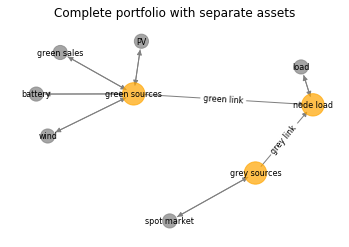

In [12]:
portfolio_separate = eao.portfolio.Portfolio([ load,link_grey,link_green,   spot_market,  wind, PV,green_sales, storage])
op_separate = portfolio_separate.setup_optim_problem(prices = prices, timegrid=timegrid)
res_separate = op_separate.optimize()
eao.network_graphs.create_graph(portf = portfolio_separate,title = 'Complete portfolio with separate assets')
#eao.network_graphs.create_graph(portf = portfolio_separate,title = '', file_name = 'full_portfolio.pdf')

(2) With the structured downstream contract as a structured asset, hiding some internal mechanics

## Optimize

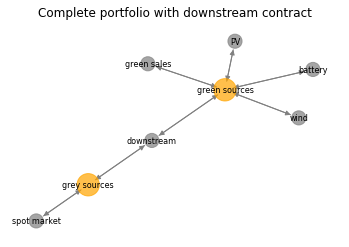

In [13]:
portfolio_struct = eao.portfolio.Portfolio([downstream_contract, wind, PV, spot_market, green_sales, storage])
op_struct = portfolio_struct.setup_optim_problem(prices = prices, timegrid=timegrid)
res_struct = op_struct.optimize()
eao.network_graphs.create_graph(portf = portfolio_struct,title = 'Complete portfolio with downstream contract')

## Interpret the results

In [14]:
output = eao.io.extract_output(portfolio_struct, op_struct, res_struct , prices)

The overall portfolio value is the following (plus an indication that the optimization was successful). In case we want to evaluate how much the promise of 80% renewable energy costs, we can easily recalculate the portcolio, changing this parameter

In [15]:
print(output['summary'])

                 Values
Parameter              
status       successful
value      57820.038998


### Detailed results
Plotting and saving results to file for further inspection 

In [16]:
eao.io.output_to_file(output,  os.path.join(os.getcwd(), 'results.xlsx'))
display(output['dispatch'][6:18].round(1))

,downstream (green sources),downstream (grey sources),wind (green sources),PV (green sources),spot market (grey sources),green sales (green sources),battery (green sources)
2021-01-01 06:00:00,-9.3,-0.0,4.7,0.0,0.0,-0.0,4.6
2021-01-01 07:00:00,-9.8,-2.9,2.5,1.3,2.9,-0.0,6.0
2021-01-01 08:00:00,-2.7,-8.1,0.2,2.5,8.1,-0.0,0.0
2021-01-01 09:00:00,-4.9,-0.0,1.5,3.5,0.0,-0.0,-0.2
2021-01-01 10:00:00,-0.0,-0.3,3.6,4.3,0.3,-0.0,-7.9
2021-01-01 11:00:00,-0.8,-0.0,4.6,4.8,0.0,-0.0,-8.7
2021-01-01 12:00:00,-2.6,-0.0,0.9,5.0,0.0,-0.0,-3.3
2021-01-01 13:00:00,-5.2,-0.0,4.4,4.8,0.0,-0.0,-4.1
2021-01-01 14:00:00,-3.4,-0.0,1.5,4.3,0.0,-0.0,-2.4
2021-01-01 15:00:00,-1.8,-0.0,3.4,3.5,0.0,-0.0,-5.2


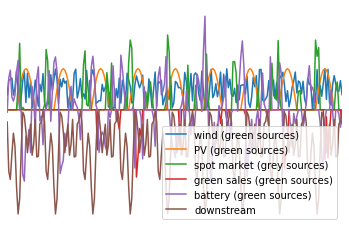

In [17]:
import matplotlib.pyplot as plt
%matplotlib inline
# take out complexity of the chart
output['dispatch']['downstream'] = output['dispatch']['downstream (green sources)'] +  output['dispatch']['downstream (grey sources)']
output['dispatch'].drop(['downstream (green sources)', 'downstream (grey sources)'], axis=1, inplace = True)
ax = output['dispatch'].plot(kind='line')
plt.axis('off')
plt.show()
